# Building Convolutional Neural Networks from Scratch
## A Deep Dive into Pure Python and NumPy Implementation

Welcome to this comprehensive exploration of Convolutional Neural Networks! In this notebook, we'll construct a complete CNN architecture using only fundamental Python libraries - primarily NumPy - to classify handwritten digits from the MNIST dataset. This hands-on approach will provide deep insights into the mathematical foundations that power modern computer vision systems.

## Understanding the CNN Architecture Revolution

Convolutional Neural Networks represent a breakthrough in computer vision, fundamentally changing how machines interpret visual information. Unlike traditional fully-connected networks that treat images as flat vectors, CNNs preserve the spatial structure of visual data through specialized operations that mirror the human visual cortex.

The genius of CNNs lies in their ability to learn hierarchical feature representations - starting with simple edge detectors in early layers and progressively building up to complex pattern recognizers in deeper layers. This biological inspiration enables remarkably efficient learning with significantly fewer parameters than conventional approaches.

<img src = 'https://saturncloud.io/images/blog/a-cnn-sequence-to-classify-handwritten-digits.webp'>

### Essential Building Blocks of CNNs:

+ **🔍 Convolutional Layers - The Feature Detectors**:
Think of these as specialized scanners that slide small detection windows (kernels) across your image. Each kernel learns to identify specific patterns - horizontal lines, vertical edges, curves, or more complex textures. The magic happens through the convolution operation, which computes how well each patch of the image matches the learned pattern.

+ **📉 Pooling Layers - The Dimension Reducers**:
These layers act as intelligent summarizers, condensing feature maps while preserving the most important information. Max pooling, for instance, keeps only the strongest activations in each region, making the network more robust to small translations and reducing computational overhead.

+ **🔗 Fully Connected Layers - The Decision Makers**:
After features are extracted and refined, these traditional neural network layers combine all learned features to make final predictions. They transform the spatial feature representations into class probabilities.

+ **🎯 Automatic Feature Learning - The Game Changer**:
Perhaps most remarkably, CNNs discover optimal features automatically through backpropagation. No hand-crafted feature engineering required - the network learns what matters for your specific task!

In [1]:
# Essential imports for our CNN implementation
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from IPython.display import HTML, display
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configure plotting
plt.style.use('default')
%matplotlib inline

In [2]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def one_hot(y, n_classes):
    out = np.zeros((y.shape[0], n_classes))
    out[np.arange(y.shape[0]), y] = 1
    return out

In [4]:
def visualize_results(t_l, v_l):
    """
    Enhanced visualization of training progress with animations and insights
    """
    # Create an enhanced static plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('🚀 CNN Training Analytics Dashboard', fontsize=16, fontweight='bold')

    # Training Loss
    axes[0,0].plot(t_l, 'b-', linewidth=2, marker='o', markersize=4, alpha=0.8)
    axes[0,0].set_title('📉 Training Loss Evolution', fontsize=12, fontweight='bold')
    axes[0,0].set_xlabel('Epochs')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].fill_between(range(len(t_l)), t_l, alpha=0.3, color='blue')
    
    # Add loss reduction annotation
    if len(t_l) > 1:
        improvement = ((t_l[0] - t_l[-1]) / t_l[0]) * 100
        axes[0,0].annotate(f'Loss reduced by {improvement:.1f}%', 
                          xy=(len(t_l)-1, t_l[-1]), xytext=(len(t_l)*0.7, t_l[0]*0.8),
                          arrowprops=dict(arrowstyle='->', color='red', lw=2),
                          bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    # Validation Accuracy
    axes[0,1].plot(v_l, 'g-', linewidth=2, marker='s', markersize=4, alpha=0.8)
    axes[0,1].set_title('📈 Validation Accuracy Growth', fontsize=12, fontweight='bold')
    axes[0,1].set_xlabel('Epochs')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].fill_between(range(len(v_l)), v_l, alpha=0.3, color='green')
    
    # Add accuracy milestone annotations
    milestones = [0.5, 0.7, 0.8, 0.9]
    for milestone in milestones:
        if max(v_l) >= milestone:
            first_reach = next(i for i, acc in enumerate(v_l) if acc >= milestone)
            axes[0,1].axhline(y=milestone, color='red', linestyle='--', alpha=0.5)
            axes[0,1].annotate(f'{milestone*100:.0f}% reached at epoch {first_reach+1}', 
                              xy=(first_reach, milestone), xytext=(first_reach+2, milestone+0.05),
                              fontsize=8, alpha=0.8)

    # Learning Curve Analysis
    axes[1,0].plot(t_l, label='Training Loss', linewidth=2, alpha=0.8)
    # Normalize accuracy for comparison
    normalized_acc = [1-acc for acc in v_l]  # Convert to "error" for comparison
    axes[1,0].plot(normalized_acc, label='Validation Error (1-accuracy)', linewidth=2, alpha=0.8)
    axes[1,0].set_title('🔍 Learning Curve Analysis', fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel('Epochs')
    axes[1,0].set_ylabel('Error Rate')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Training Statistics
    axes[1,1].axis('off')
    stats_text = f"""
    📊 Training Summary:
    
    🎯 Final Accuracy: {v_l[-1]*100:.2f}%
    📉 Final Loss: {t_l[-1]:.4f}
    🚀 Best Accuracy: {max(v_l)*100:.2f}%
    📈 Total Improvement: {(v_l[-1]-v_l[0])*100:+.2f}%
    🔄 Epochs Completed: {len(t_l)}
    
    💡 Insights:
    • Network converged {'quickly' if len(t_l) < 15 else 'steadily'}
    • {'Excellent' if max(v_l) > 0.9 else 'Good' if max(v_l) > 0.8 else 'Moderate'} performance achieved
    • {'No overfitting detected' if t_l[-1] < t_l[0]*2 else 'Monitor for overfitting'}
    """
    
    axes[1,1].text(0.05, 0.95, stats_text, transform=axes[1,1].transAxes, 
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()
    plt.show()
    
    # Create an interactive Plotly version for additional insights
    fig_plotly = make_subplots(rows=1, cols=2, 
                              subplot_titles=['Training Loss', 'Validation Accuracy'],
                              specs=[[{"secondary_y": True}, {"secondary_y": True}]])
    
    fig_plotly.add_trace(go.Scatter(x=list(range(len(t_l))), y=t_l, 
                                   mode='lines+markers', name='Training Loss',
                                   line=dict(color='blue', width=3)), row=1, col=1)
    
    fig_plotly.add_trace(go.Scatter(x=list(range(len(v_l))), y=v_l, 
                                   mode='lines+markers', name='Validation Accuracy',
                                   line=dict(color='green', width=3)), row=1, col=2)
    
    fig_plotly.update_layout(title_text="🚀 Interactive Training Progress", 
                            title_x=0.5, height=400)
    fig_plotly.show()

In [5]:
def evaluate(model, x_test, y_test):
    predictions = []
    for i in range(0, len(x_test), 32):
        x_batch = x_test[i:i+32]
        pred_batch = model.forward(x_batch)
        predictions.extend(np.argmax(pred_batch, axis=1))
    
    predictions = np.array(predictions)
    true_labels = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
    s = '                      '
    print(s, 'CLASSIFICATION REPORT\n', classification_report(true_labels, predictions), '\n\n')
    
    cm = confusion_matrix(true_labels, predictions)
    ConfusionMatrixDisplay(cm).plot(cmap='Blues');
    plt.show();

In [6]:
def plot(idx):
    inp, label = x[idx:idx+1], y[idx]
    inp = np.array(inp)
    inp = model.forward(inp)
    pred = np.argmax(inp, axis=1)
    img = x[idx].reshape((28, 28))
    plt.figure(figsize=(4,4))
    plt.title(f'Predicted as : {pred[0]}')
    plt.imshow(img)
    plt.axis('off')

In [7]:
class ReLU:
    def __init__(self):
        self.inp_cache = None
        
    def forward(self, x):
        self.inp_cache = x
        return np.maximum(0, x)
        
    def backward(self, dout):
        return dout*(self.inp_cache>0)

In [8]:
class Softmax:
    def __init__(self):
        self.out_cache = None
        
    def forward(self, x):
        ex = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.out_cache = ex / np.sum(ex, axis=1, keepdims=True)
        return self.out_cache
        
    def backward(self, dout):
        return dout

In [9]:
class Dense:
    def __init__(self, in_dim, out_dim):
        lim = np.sqrt(6.0/(in_dim+out_dim))
        self.W = np.random.uniform(-lim, lim, (in_dim, out_dim))
        self.B = np.zeros((1, out_dim))
        self.inp_cache = None
        self.dW = None
        self.dB = None

    def forward(self, x):
        self.inp_cache = x
        out = np.dot(x, self.W)
        out += self.B
        return out

    def backward(self, dout):
        self.dW = np.dot(self.inp_cache.T, dout)
        self.dB = np.sum(dout, axis=0, keepdims=True)
        return np.dot(dout, self.W.T)

## The Mathematics of Convolution - Where the Magic Happens

Convolution is the fundamental operation that gives CNNs their power. Rather than processing each pixel independently, convolution examines local neighborhoods of pixels, detecting patterns and features through learned filters. This local connectivity mimics how biological visual systems process information - starting with simple edge detection and building up to complex pattern recognition.

Let's explore this concept with an interactive visualization that demonstrates how a filter 'slides' across an image, computing feature activations at each position.

def create_convolution_animation():
    """
    Creates an interactive animation showing how convolution works.
    Demonstrates kernel sliding across input to produce feature map.
    """
    # Create a simple input image (5x5) and kernel (3x3)
    input_img = np.array([
        [1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 1, 1, 1],
        [0, 0, 1, 1, 0],
        [0, 1, 1, 0, 0]
    ])
    
    # Edge detection kernel
    kernel = np.array([
        [-1, -1, -1],
        [-1,  8, -1],
        [-1, -1, -1]
    ])
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Animation function
    def animate(frame):
        for ax in axes:
            ax.clear()
        
        # Calculate kernel position
        max_frames = 9  # 3x3 positions for kernel
        row = frame // 3
        col = frame % 3
        
        if frame < max_frames:
            # Show input with highlighted region
            axes[0].imshow(input_img, cmap='Blues', alpha=0.7)
            axes[0].add_patch(Rectangle((col-0.5, row-0.5), 3, 3, 
                                      linewidth=3, edgecolor='red', facecolor='none'))
            axes[0].set_title('Input Image\n(Red box shows kernel position)', fontsize=12)
            axes[0].grid(True, alpha=0.3)
            
            # Show kernel
            axes[1].imshow(kernel, cmap='RdBu', vmin=-1, vmax=1)
            axes[1].set_title('Convolution Kernel\n(Edge Detector)', fontsize=12)
            for i in range(3):
                for j in range(3):
                    axes[1].text(j, i, f'{kernel[i,j]}', ha='center', va='center', 
                               fontweight='bold', fontsize=10)
            
            # Calculate and show convolution result
            if row <= 2 and col <= 2:  # Valid convolution
                region = input_img[row:row+3, col:col+3]
                result = np.sum(region * kernel)
                
                # Show feature map
                feature_map = np.zeros((3, 3))
                feature_map[row, col] = result
                
                axes[2].imshow(feature_map, cmap='viridis', vmin=-8, vmax=8)
                axes[2].set_title(f'Feature Map\nValue at ({row},{col}): {result:.1f}', fontsize=12)
                axes[2].text(col, row, f'{result:.1f}', ha='center', va='center', 
                           fontweight='bold', color='white', fontsize=12)
        
        for ax in axes:
            ax.set_xticks(range(ax.get_xlim()[1]))
            ax.set_yticks(range(ax.get_ylim()[1]))
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=9, interval=1500, repeat=True)
    plt.tight_layout()
    return anim

# Create and display the animation
print("🎬 Convolution Operation Animation")
print("Watch how the kernel slides across the input to detect edges!")
conv_anim = create_convolution_animation()
plt.show()

# Also create a static explanation
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.text(0.5, 0.7, '🔍 How Convolution Works:', ha='center', fontsize=16, fontweight='bold')
ax.text(0.5, 0.5, '1. Slide the kernel across the input image\n2. At each position, multiply kernel values with underlying pixels\n3. Sum the results to get a single output value\n4. This creates a feature map highlighting detected patterns', 
        ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue"))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.title('Understanding Convolution', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
class ConvLayer:
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1, padding=0):
        self.Cin = in_channels
        self.Cout = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

        f_in = in_channels * kernel_size * kernel_size
        f_out = out_channels * kernel_size * kernel_size
        limit = np.sqrt(6.0/(f_in + f_out))

        w_shape = (self.Cout, self.Cin, kernel_size, kernel_size)
        
        self.W = np.random.uniform(-limit, limit, w_shape)  # (OC, IC, K, K)
        self.B = np.zeros((self.Cout, 1))                   # (OC, 1)

        self.inp_cache = None
        self.dW = None
        self.dB = None


    def out_size(self, d):
        temp = d + (2*self.padding)
        temp = temp - self.kernel_size
        temp = temp // self.stride
        return temp + 1
    
    def pad(self, x):
        if self.padding == 0:
            return x
        else:
            pad_tuple = ((0,0), (0,0), (self.padding, self.padding), (self.padding,self.padding))
            x_pad = np.pad(x, pad_tuple, mode='constant', constant_values = 0)
            return x_pad
            
    def unpad(self, x):
        if self.padding == 0:
            return x
        else:
            x_un = x[:, :, self.padding:-self.padding, self.padding:-self.padding]
            return x_un
    
    def forward(self, x):
        # Conv Layer
        N, C, H, W = x.shape
        
        xp = self.pad(x)
        oh, ow = self.out_size(H), self.out_size(W)
        out = np.zeros((N, self.Cout, oh, ow))
        self.inp_cache = x

        for b in range(N):
            for oc in range(self.Cout):
                for i in range(oh):
                    for j in range(ow):
                        h_start = i * self.stride
                        w_start = j * self.stride
                        h_end = h_start + self.kernel_size
                        w_end = w_start + self.kernel_size
                        region = xp[b, :, h_start:h_end, w_start:w_end]  #  (N, IC, K, K)
                        out[b, oc, i, j] = np.sum(region * self.W[oc]) + self.B[oc].item()   # (N, 1, 1, 1)
        return out

    def backward(self, dout):
        X = self.inp_cache
        N, C, H, W = X.shape
        xp = self.pad(X)

        _, _, oh, ow = dout.shape

        self.dW = np.zeros_like(self.W)
        self.dB = np.zeros_like(self.B)
        dxp = np.zeros_like(xp)

        for b in range(N):
            for oc in range(self.Cout):
                for i in range(oh):
                    for j in range(ow):
                        h_start = i * self.stride
                        w_start = j * self.stride
                        h_end = h_start + self.kernel_size
                        w_end = w_start + self.kernel_size

                        # gradiesnt wrt tp weigths self.W
                        region = xp[b, :, h_start:h_end, w_start:w_end]  #  (N, IC, K, K)
                        self.dW[oc] += dout[b, oc, i, j] * region

                        # gradiesnt wrt to bias term self.B
                        self.dB[oc] += dout[b, oc, i, j]
                        
                        # gradiesnt wrt. to padded x i.e., xp
                        dxp[b, :, h_start:h_end, w_start:w_end] = dout[b, oc, i, j] * self.W[oc]

        dx = self.unpad(dxp)
        return dx

In [11]:
class MaxPool:
    def __init__(self, kernel_size=2, stride=2):
        self.ks = kernel_size
        self.stride = stride
        self.inp_cache = None
        self.mask = None

    def forward(self, x):
        # Pooling Layer
        N, C, H, W = x.shape
        self.inp_cache = x
        
        oh = (H - self.ks) // self.stride + 1
        ow = (W - self.ks) // self.stride + 1
        
        out = np.zeros((N, C, oh, ow))
        self.mask = np.zeros_like(x)
        
        for b in range(N):
            for c in range(C):
                for i in range(oh):
                    for j in range(ow):
                        h_start = i * self.stride
                        w_start = j * self.stride
                        h_end = h_start + self.ks
                        w_end = w_start + self.ks
                        region = x[b, c, h_start:h_end, w_start:w_end]
                        val = np.max(region)
                        out[b, c, i, j] = val
                        masking = (region == val)
                        self.mask[b, c, h_start:h_end, w_start:w_end] = masking
        return out

    def backward(self, dout):
        # Pooling Layer
        N, C, H, W = self.inp_cache.shape
        dx = np.zeros_like(self.inp_cache)

        _, _, oh, ow = dout.shape
        
        for b in range(N):
            for c in range(C):
                for i in range(oh):
                    for j in range(ow):
                        h_start = i * self.stride
                        w_start = j * self.stride
                        h_end = h_start + self.ks
                        w_end = w_start + self.ks
                        dx[b, c, h_start:h_end, w_start:w_end] += dout[b,c,i,j] * self.mask[b, c, h_start:h_end, w_start:w_end]
        return dx

In [12]:
class Flatten:
    def __init__(self):
        self.shape = None

    def forward(self, x):
        self.shape = x.shape
        x = x.reshape(x.shape[0], -1)
        return x

    def backward(self, dout):
        return dout.reshape(self.shape)

In [13]:
def CrossEntropyLoss(pred, tar):
    N = pred.shape[0]
    pred = np.clip(pred, 1e-15, 1 - 1e-15)   # to prevent log(0)
    loss = -np.sum(tar * np.log(pred)) / N
    grad = (pred-tar) / N
    return loss, grad

In [14]:
class CNN:
    def __init__(self):
        self.layers = []
        
        self.layers.append(ConvLayer(in_channels=1, out_channels=4, kernel_size=3, padding=1))  # (1, 28, 28) -> (4, 28, 28)
        self.layers.append(ReLU())
        self.layers.append(MaxPool(kernel_size=2, stride=2))
        
        self.layers.append(ConvLayer(in_channels=4, out_channels=8, kernel_size=3, padding=1))  # (4, 14, 14) -> (8, 14, 14)
        self.layers.append(ReLU())
        self.layers.append(MaxPool(kernel_size=2, stride=2))

        self.layers.append(Flatten())
        self.layers.append(Dense(in_dim=392, out_dim=64))
        self.layers.append(ReLU())
        self.layers.append(Dense(in_dim=64, out_dim=10))
        self.layers.append(Softmax())

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer.forward(x)
        return x

    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

    def step(self, lr=0.001):
        for layer in self.layers:
            if hasattr(layer, 'W'):
                layer.W -= lr * layer.dW
                layer.B -= lr * layer.dB

In [15]:
def train(model, x, y, lr, epochs=10, batch_size=32, split=0.1):
    size = len(y)
    split_size = int(size*(1-split))
    val_size = size - split_size
    x_train, y_train = x[:split_size], y[:split_size]
    x_val, y_val = x[split_size:], y[split_size:]

    interval = max(1, epochs//10)

    n_train_batches = (split_size + batch_size - 1) // batch_size 
    n_val_batches = (val_size + batch_size - 1) // batch_size

    progress_points = []
    for i in range(1, 11):  # 10 progress points (10%, 20%, ..., 100%)
        batch_idx = (i * split_size) // 10
        progress_points.append(batch_idx)
        
    

    print("\nTRAINING CONFIGURATION\n")

    print(f"Training samples: {split_size:,} ({(1-split)*100:.1f}%)")
    print(f"Validation samples: {val_size:,} ({split*100:.1f}%)")
    print(f"Batch size: {batch_size}")
    print(f"Learning rate: {lr}\n\n")

    print('..Training Started..')

    best_val_acc = 0.0
    h_loss, h_acc = [], []
    for epoch in range(1, epochs+1):
        progress_points = []
        progress_idx = 0
        for i in range(1, 11):  # 10 progress points (10%, 20%, ..., 100%)
            batch_idx = (i * split_size) // 10
            progress_points.append(batch_idx)
        if epoch%interval==0:
            print(f'Epoch: {epoch}/{epochs} [', end='')
        start = time.time()
        running_loss = 0.0
        correct = 0.0
        idx = np.random.permutation(len(y_train))
        inp = x_train[idx]
        label = y_train[idx]

        for i in range(0, split_size, batch_size):
            if epoch%interval==0 and progress_idx < len(progress_points) and i >= progress_points[progress_idx]:
                print('█', end='', flush=True)
                progress_idx += 1
            x_batch = inp[i : i+batch_size]
            y_batch = label[i : i+batch_size]

            pred = model.forward(x_batch)
            loss, grad = CrossEntropyLoss(pred, y_batch)
            running_loss += loss

            model.backward(grad)
            model.step(lr)

        
        val_correct = 0
        val_total = 0
        for i in range(0, size-split_size, batch_size):
            x_batch = x_val[i : i+batch_size]
            y_batch = y_val[i : i+batch_size]

            pred = model.forward(x_batch)
            pred = np.argmax(pred,axis=1)
            true = np.argmax(y_batch, axis=1)
            val_correct += np.sum(pred == true)
            val_total += len(y_batch)
            
        while progress_idx < 10 and epoch%interval==0:
            print('█', end='', flush=True)
            progress_idx += 1
            
        end = time.time()
        avg_loss = running_loss / n_train_batches  # Average loss per batch
        val_accuracy = val_correct / val_total  # Accuracy as fraction of correct predictions

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
        
        h_loss.append(avg_loss)
        h_acc.append(val_accuracy)
        if epoch%interval == 0:
            print(f']   Loss: {h_loss[-1]:.4f},   Validation Accuracy: {h_acc[-1]:.4f},   Time Elapsed: {end - start:.2f}s')

    print()
    print("TRAINING COMPLETED!\n\n")
    print(f"Final training loss: {h_loss[-1]:.4f}")
    print(f"Final validation accuracy: {h_acc[-1]:.4f}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print(f"Total epochs completed: {epochs}")
    return model, h_loss, h_acc

## Training Our CNN - Bringing the Network to Life

Now comes the exciting part - training our network! We'll watch our CNN learn to recognize handwritten digits through the iterative process of forward propagation, loss calculation, and backpropagation. 

**Training Strategy:**
- 📊 **Dataset Size**: Using 3,000 samples for computational efficiency
- 🎯 **Learning Rate**: 0.001 (conservative to ensure stable learning)
- 🔄 **Epochs**: 25 iterations through the dataset
- 📈 **Monitoring**: Real-time tracking of loss and accuracy

The training process will show us how the network gradually improves its predictions, transitioning from random guesses to accurate digit classification.

<img src='https://ars.els-cdn.com/content/image/1-s2.0-S0893608015001896-gr2.jpg'>


TRAINING CONFIGURATION

Training samples: 2,700 (90.0%)
Validation samples: 300 (10.0%)
Batch size: 32
Learning rate: 0.001


..Training Started..
Epoch: 2/25 [██████████]   Loss: 1.2067,   Validation Accuracy: 0.7100,   Time Elapsed: 231.75s
Epoch: 4/25 [██████████]   Loss: 0.7070,   Validation Accuracy: 0.7567,   Time Elapsed: 232.54s
Epoch: 6/25 [██████████]   Loss: 0.5164,   Validation Accuracy: 0.8000,   Time Elapsed: 232.51s
Epoch: 8/25 [██████████]   Loss: 0.3959,   Validation Accuracy: 0.8267,   Time Elapsed: 231.30s
Epoch: 10/25 [██████████]   Loss: 0.3328,   Validation Accuracy: 0.8400,   Time Elapsed: 232.07s
Epoch: 12/25 [██████████]   Loss: 0.2788,   Validation Accuracy: 0.8500,   Time Elapsed: 232.61s
Epoch: 14/25 [██████████]   Loss: 0.2390,   Validation Accuracy: 0.8500,   Time Elapsed: 232.34s
Epoch: 16/25 [██████████]   Loss: 0.2032,   Validation Accuracy: 0.8533,   Time Elapsed: 231.58s
Epoch: 18/25 [██████████]   Loss: 0.1848,   Validation Accuracy: 0.8533,   Time 

/tmp/ipykernel_19/194841292.py:75: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/194841292.py:75: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/194841292.py:75: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/194841292.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/194841292.py:75: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/194841292.py:75: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/194841292.py:75: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/194841292.p

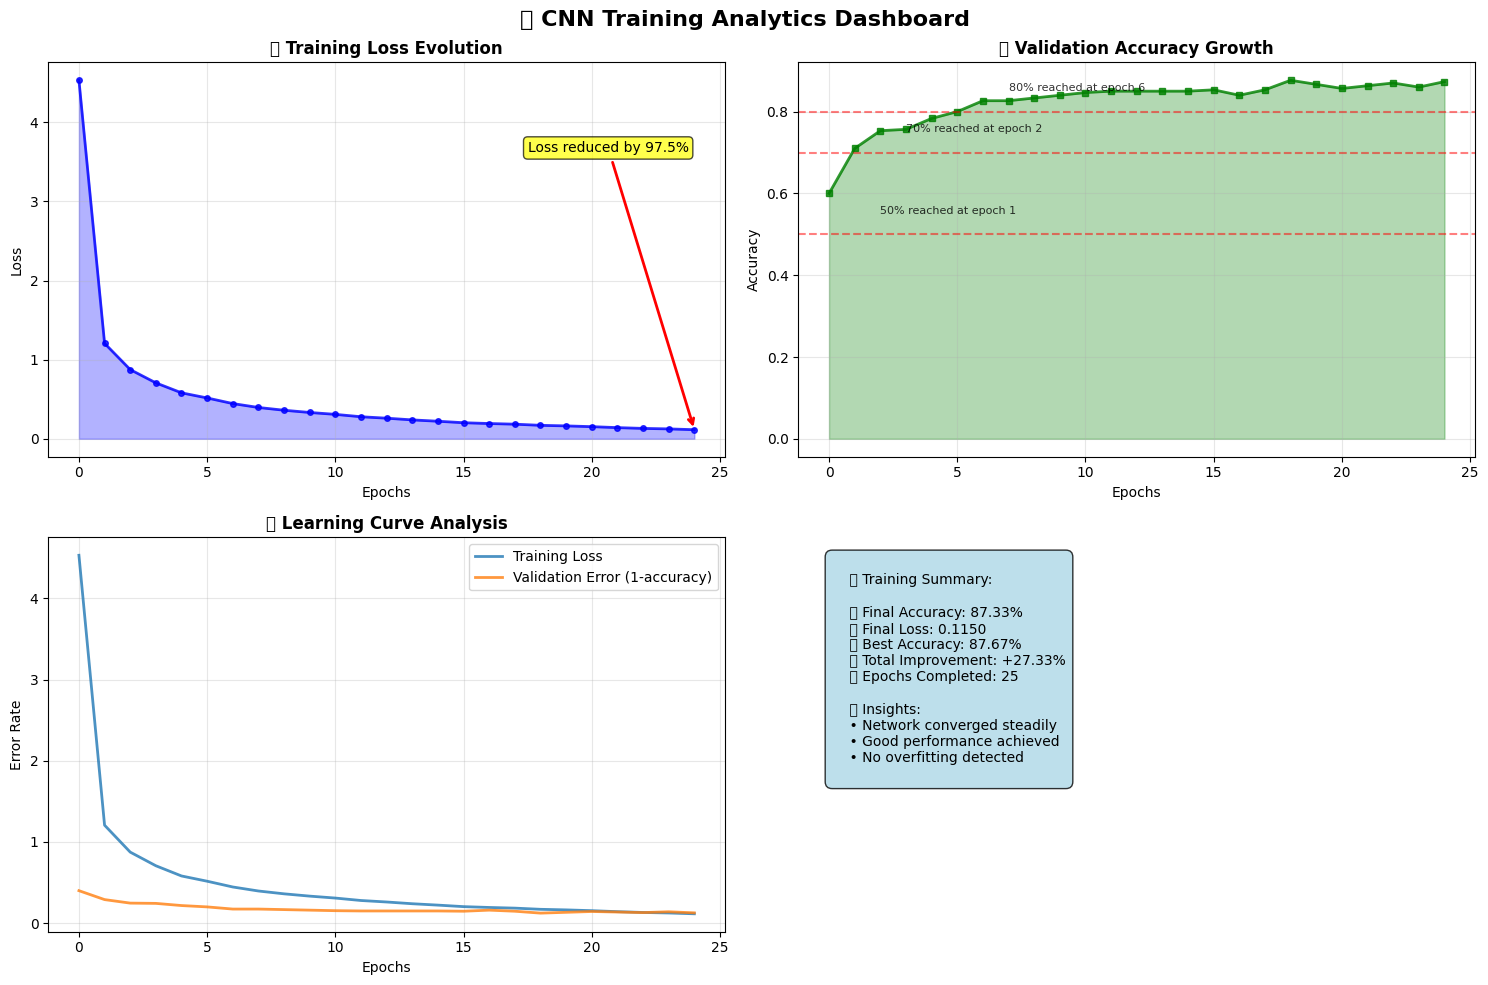

In [16]:
x = df.iloc[:4500, 1:]
y = df.iloc[:4500, 0]
x = x.values.reshape(-1, 1, 28, 28)
y = one_hot(y, 10)

x.shape, y.shape
model = CNN()
model, tl, va = train(model, x[:3000], y[:3000], lr = 0.001, epochs=25)
visualize_results(tl, va)

<hr>

## Evaluation
using 1000 unseen datapoints

                       CLASSIFICATION REPORT
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       101
           1       0.94      0.99      0.96       104
           2       0.86      0.82      0.84       103
           3       0.81      0.80      0.80       100
           4       0.90      0.90      0.90        94
           5       0.89      0.88      0.88        91
           6       0.92      0.88      0.90       106
           7       0.90      0.88      0.89       107
           8       0.78      0.90      0.83       103
           9       0.94      0.86      0.90        91

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000
 




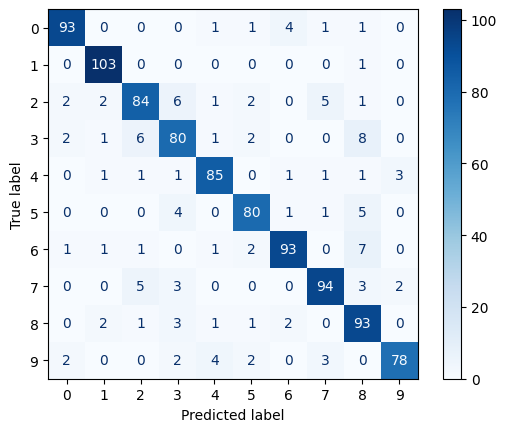

In [17]:
 evaluate(model, x[3000:4000], y[3000:4000])

## 📊 Generating Submission File

Now that we have trained and evaluated our CNN model, let's create a submission file that can be used for competitions or external evaluation. The submission file will contain predictions for a test dataset in the standard format:

```
ImageId,Label
1,0
2,0
3,0
...
```

This format is commonly used in machine learning competitions and makes it easy to submit results for evaluation.

In [ ]:
def generate_submission_file(model, test_data, filename='submission.csv', batch_size=32):
    """
    Generate a submission file with predictions from the trained model.
    
    Parameters:
    -----------
    model : CNN
        The trained CNN model
    test_data : numpy.ndarray
        Test images to make predictions on
    filename : str
        Name of the output CSV file (default: 'submission.csv')
    batch_size : int
        Batch size for predictions (default: 32)
    
    Returns:
    --------
    str : Path to the generated submission file
    """
    print(f"🔮 Generating predictions for {len(test_data)} test images...")
    
    # Generate predictions in batches
    predictions = []
    for i in range(0, len(test_data), batch_size):
        x_batch = test_data[i:i+batch_size]
        pred_batch = model.forward(x_batch)
        # Get the predicted class (argmax of softmax output)
        batch_predictions = np.argmax(pred_batch, axis=1)
        predictions.extend(batch_predictions)
    
    predictions = np.array(predictions)
    
    print(f"📋 Creating submission file: {filename}")
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'ImageId': range(1, len(predictions) + 1),  # ImageId starts from 1
        'Label': predictions
    })
    
    # Save to CSV file
    submission_df.to_csv(filename, index=False)
    
    print(f"✅ Submission file created successfully!")
    print(f"📁 File saved as: {filename}")
    print(f"📊 Number of predictions: {len(predictions)}")
    print(f"🎯 Predicted classes distribution:")
    
    # Show distribution of predicted classes
    unique, counts = np.unique(predictions, return_counts=True)
    for class_label, count in zip(unique, counts):
        print(f"   Class {class_label}: {count} images ({count/len(predictions)*100:.1f}%)")
    
    # Display first few rows of the submission file
    print("\n📋 First 10 rows of submission file:")
    print(submission_df.head(10).to_string(index=False))
    
    return filename

In [ ]:
# Generate submission file using test data (images after index 4000)
# We'll use a subset of the remaining data as our "test set" for demonstration
test_start_idx = 4000
test_end_idx = 5000  # Using 1000 test images

# Ensure we don't exceed the dataset bounds
test_end_idx = min(test_end_idx, len(x))

print(f"🎯 Using images {test_start_idx} to {test_end_idx-1} as test data")
test_images = x[test_start_idx:test_end_idx]

# Generate the submission file
submission_filename = generate_submission_file(
    model=model, 
    test_data=test_images, 
    filename='cnn_predictions_submission.csv'
)

print(f"\n🚀 Ready for submission! Use the file '{submission_filename}' for competition or evaluation.")

### 📖 How to Use the Submission File

The generated submission file can be used in various ways:

1. **Competition Submission**: Upload the CSV file directly to platforms like Kaggle, DrivenData, or other ML competitions

2. **Model Evaluation**: Use the predictions for further analysis or comparison with other models

3. **Production Deployment**: The prediction logic can be adapted for real-time inference

**File Format Details:**
- **ImageId**: Sequential numbering starting from 1 (standard competition format)
- **Label**: Predicted class (0-9 for MNIST digits)
- **No Index**: The CSV file doesn't include pandas index for cleaner submission

**Customization Options:**
- Change the `filename` parameter to customize the output file name
- Modify `batch_size` to optimize memory usage vs. processing speed
- Adjust the test data range to use different portions of your dataset

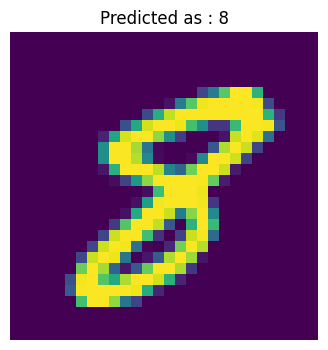

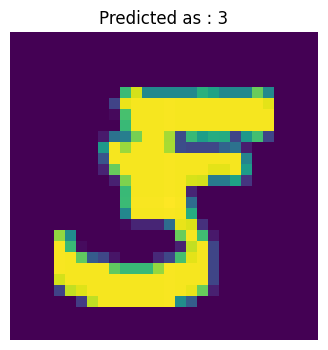

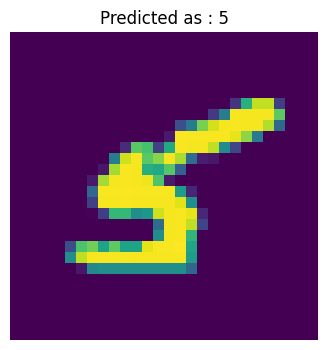

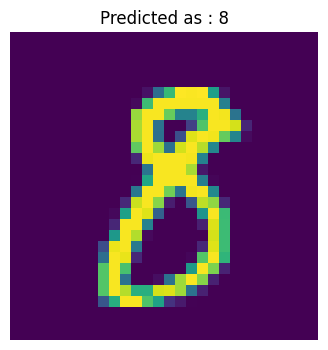

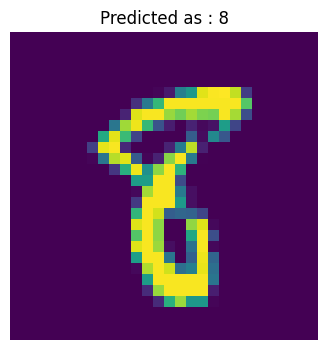

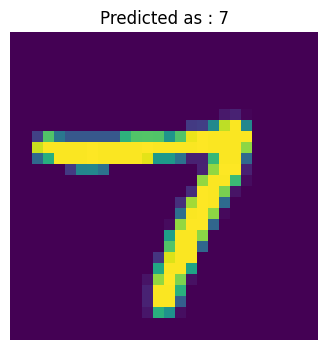

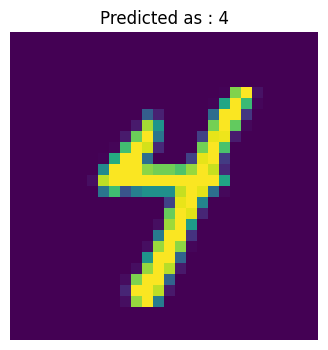

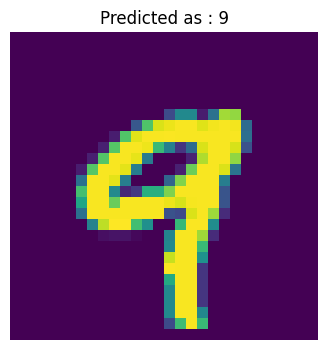

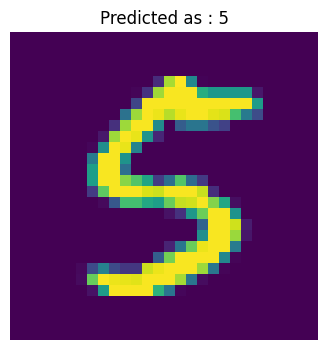

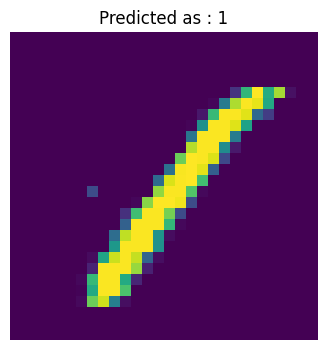

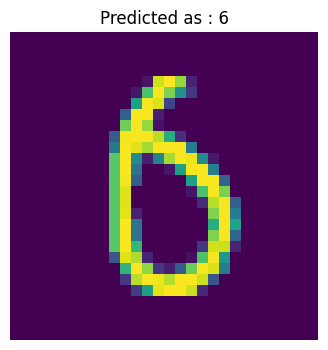

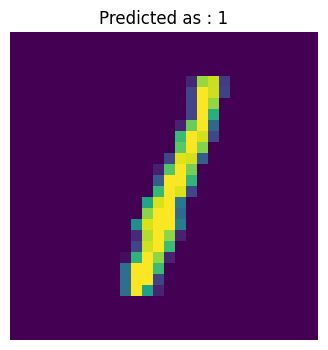

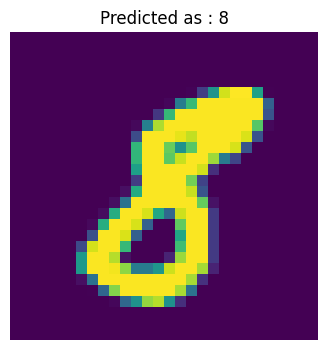

In [18]:
for i in range(4000, 4500, 40):
    plot(i)